In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pickle
from moviepy.editor import VideoFileClip
from camera_calibration import CameraCalibration
from birdseye import BirdsEye
from threshold import Thresholding
from lane_detection import LaneDetection
#from line import Line
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from imageio import imread
%matplotlib inline

#  Helper Functions

In [2]:
def plot_images_adj(img1, img2, text1, text2) :
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[0].set_title(text1)
    ax[1].set_title(text2)
    plt.show()

# 1. Camera Calibration

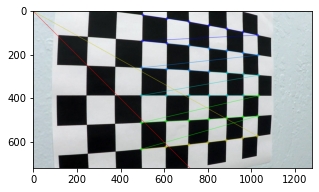

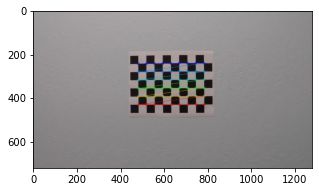

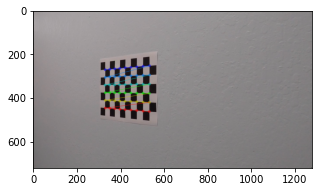

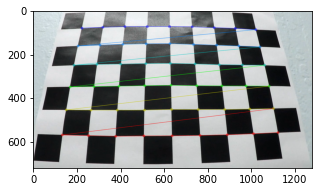

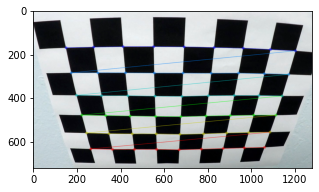

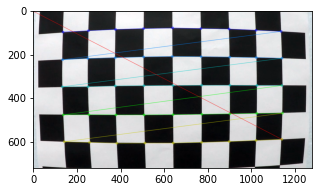

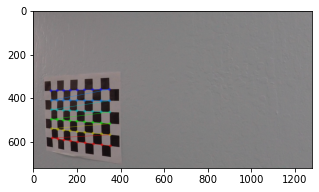

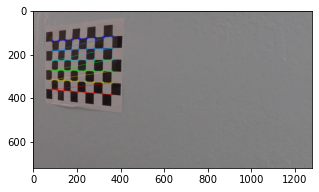

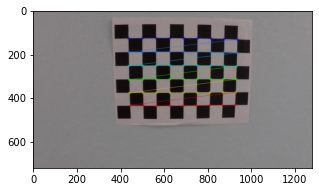

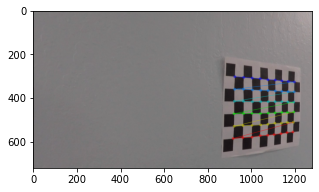

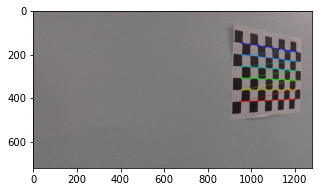

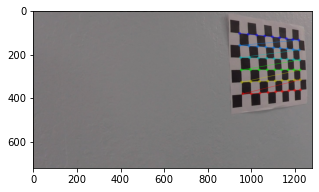

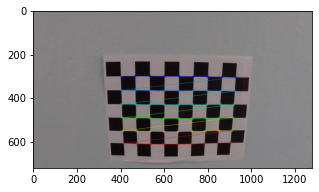

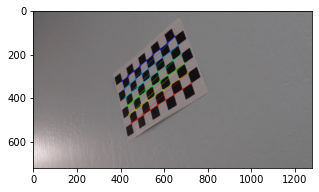

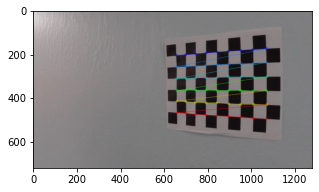

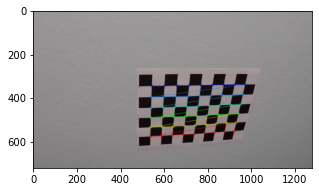

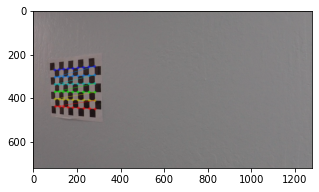

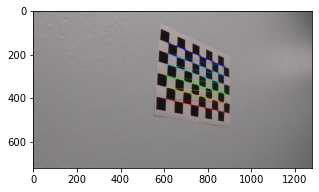

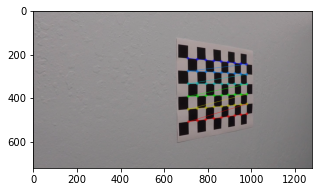

In [3]:
# Calibrating the car camera using chessboard corners detection.

directory = 'camera_cal/'
images = glob.glob(os.path.join(directory, 'calibration*.jpg'))

cam_cal = CameraCalibration()

mtx, dist = cam_cal.camera_calibration(images, nx = 9, ny = 6, draw = True)

## Code to save camera calibration result as a pickle file

In [4]:
cal_pickle = {}
cal_pickle['mtx'] = mtx
cal_pickle['dist'] = dist
with open('camera_cal/cal_pickle.p','wb') as output_file:
    pickle.dump(cal_pickle, output_file)

## Read the camera calibration pickle

In [5]:
with open('camera_cal/cal_pickle.p', 'rb') as input_file:
    p = pickle.load(input_file)
mtx = p['mtx']
dist = p['dist']

# 2. Performing Distortion Correction

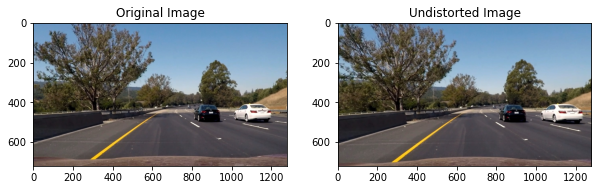

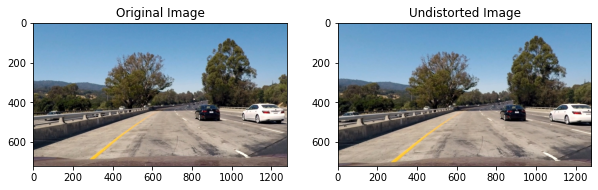

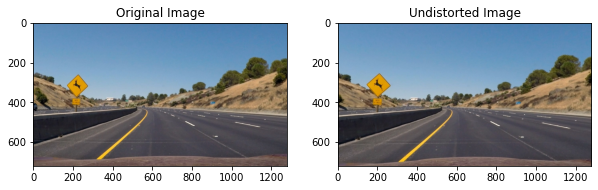

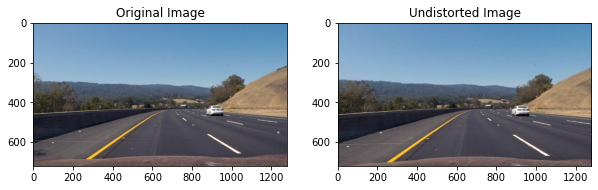

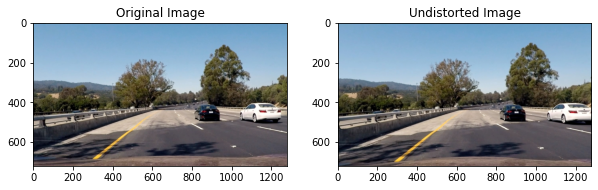

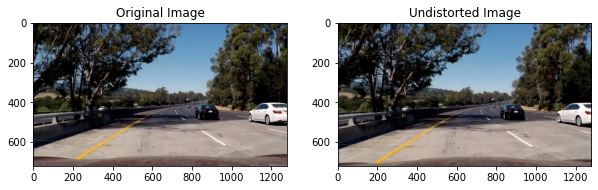

In [6]:
# Applying distortion on the test images
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpeg'))

for fname in test_imgs:
    # Get the original image
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    # Get the undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Plotting the images side by side
    plot_images_adj(img1=img, img2=undist, text1='Original Image', text2='Undistorted Image')
    
plt.show()

# 3. Performing Perspective Transform

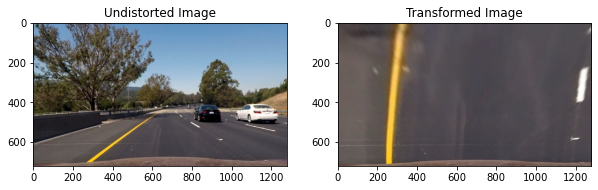

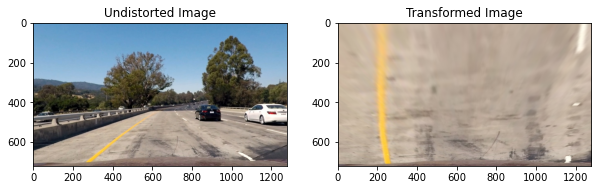

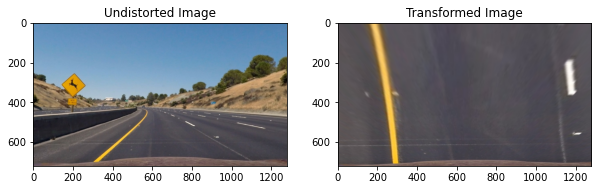

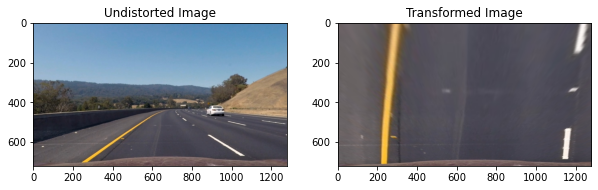

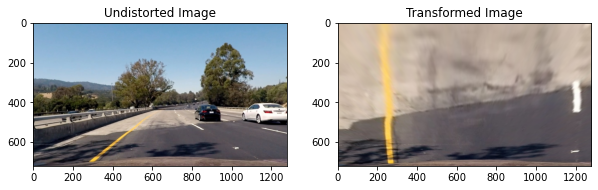

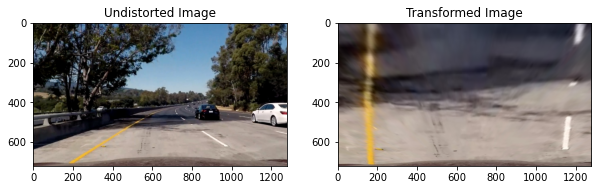

In [7]:
# pixel numbers for the images
src = np.float32([(300,720),(1100,720),(730,480),(580,480)])
dst = np.float32([(300,720),(1100,720),(1100,0),(300,0)])

birdseye = BirdsEye(src, dst)

# Fetch the transform matrices 
M, Minv = birdseye.PerspectiveTransform()

# Get all trhe images using incremental naming convention
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpeg'))

for fname in test_imgs:
    
    # Getting the original image
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    # Getting the undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Getting the birdseye view image
    birdseyeView = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    # Plotting the images side by side
    plot_images_adj(img1=undist, img2=birdseyeView, text1='Undistorted Image', text2='Transformed Image')
    
plt.show()

# 4. Applying Thresholding

In [8]:
# Function that takes an image, gradient orientation, and threshold min / max values.

def abs_sobel_thresh(img, orient = 'x', thresh_min = 0, thresh_max = 255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy of the image
    binary = np.zeros_like(scaled_sobel)
    # Apply the threshold
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary

def thresholding(img, s_thresh=(170, 255), sx_thresh=(30, 255)):   
    # Sobel x 
    sobel_x = abs_sobel_thresh(img, 'x', 30, 255)
    
    # White and yellow from RGB
    rgb_white = cv2.inRange(img, (200, 200, 200), (255, 255, 255))
    rgb_yellow = cv2.inRange(img, (20, 100, 100), (50, 255, 255))
    
    # White and yellow from HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_white = cv2.inRange(hsv, (200, 200, 200), (255, 255, 255))
    hsv_yellow = cv2.inRange(hsv, (20, 100, 100), (50, 255, 255))
    
    # S channel from HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    s_output = np.zeros_like(s)
    s_output[(s > 170) & (s <= 255)] = 1
    
    # White and yellow from HLS
    hls_white = cv2.inRange(hls, (200,200,200), (255,255,255))
    hls_yellow = cv2.inRange(hls, (20, 100, 100), (50, 255, 255))

    masked = sobel_x | s_output | rgb_white | rgb_yellow | hsv_white | hsv_yellow | hls_white | hls_yellow
    return masked    

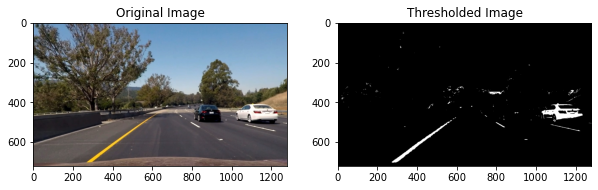

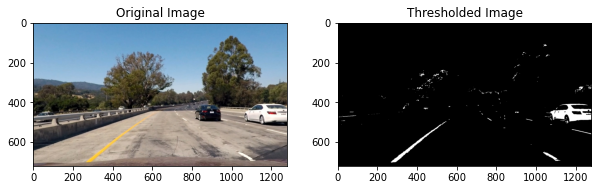

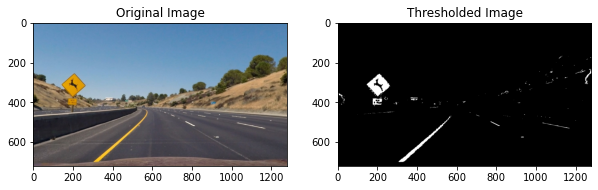

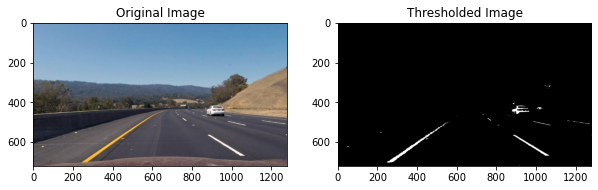

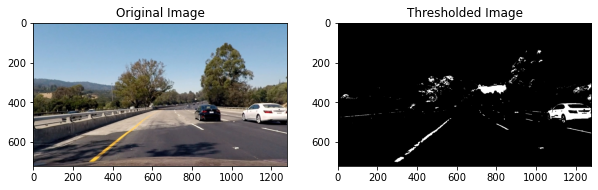

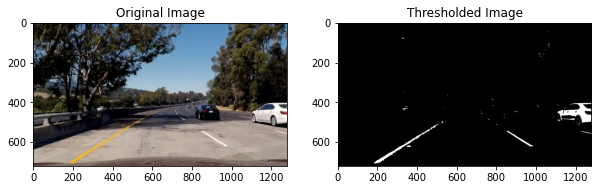

In [9]:
#Applying threshold on undistorted image

test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpeg'))
for fname in test_imgs:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    masked = thresholding(undist, 'x')
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    
    # Plotting the images side by side
    ax[0].imshow(undist)
    ax[0].set_title('Original Image')
    ax[1].imshow(masked, cmap = 'gray')
    ax[1].set_title('Thresholded Image')
    plt.show()

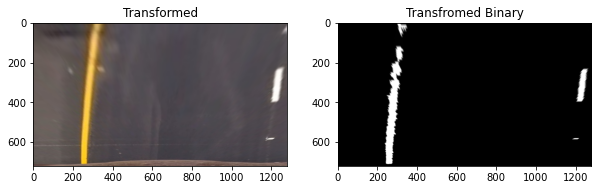

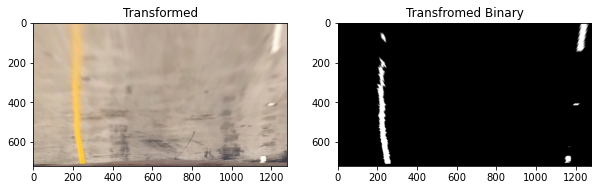

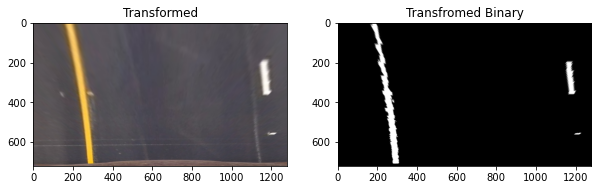

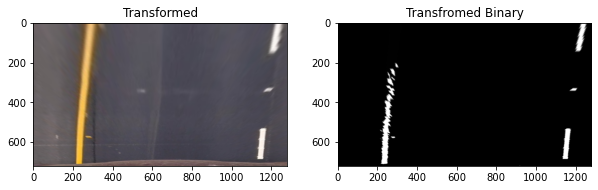

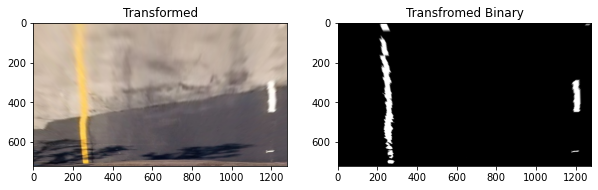

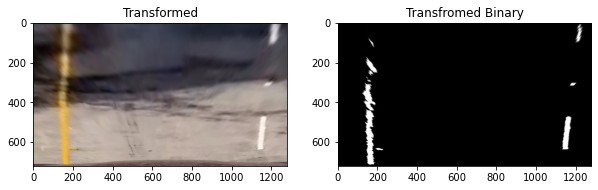

In [10]:
# Apply threshold on skyview images

# Get all trhe images using incremental naming convention
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpeg'))

for fname in test_imgs:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    masked = thresholding(undist)
    transformed = cv2.warpPerspective(undist, M, (1280, 720), flags=cv2.INTER_LINEAR)
    binary_transformed = cv2.warpPerspective(masked, M, (1280, 720), flags=cv2.INTER_LINEAR)
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(transformed)
    ax[0].set_title('Transformed')
    ax[1].imshow(binary_transformed, cmap = 'gray')
    ax[1].set_title('Transfromed Binary')
    plt.show()

# 5. Lane Detection

In [11]:
# Defining the conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

lane_detection = LaneDetection(ym_per_pix, xm_per_pix, Minv)

def lane_detection_pipeline(fname):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    
    # Get the undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #Applying threshold
    transformed = thresholding(undist)
    
    #Getting birdseye
    birdseye_undist = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    birdseye_transformed = cv2.warpPerspective(transformed, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    result, left_x, left_y, right_x, right_y, left_fitx, left_y_ext, right_fitx, right_y_ext = \
    lane_detection.FindLines(birdseye_transformed,undist, 80)
    
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(birdseye_undist)
    ax[0].scatter(left_x, left_y, c = 'r')
    ax[0].scatter(right_x, right_y, c = 'b')
    ax[0].plot(left_fitx, left_y_ext, color='green', linewidth=3)
    ax[0].plot(right_fitx, right_y_ext, color='green', linewidth=3)
    ax[0].set_xlim([0, 1280])
    ax[0].set_ylim([0, 720])
    ax[1].imshow(result)
    plt.show()



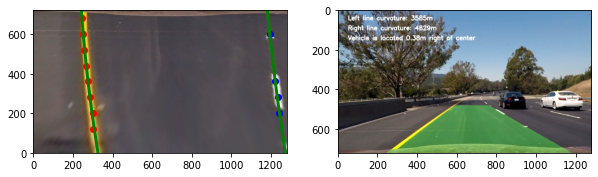

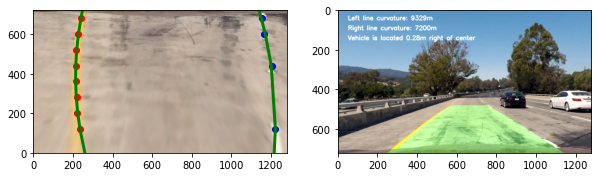

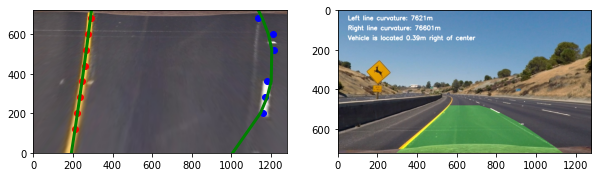

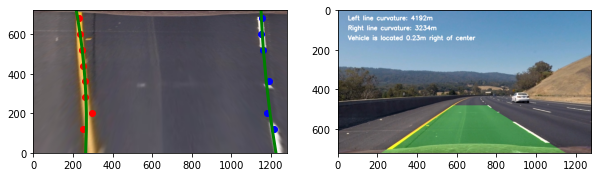

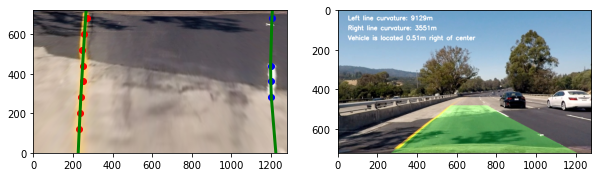

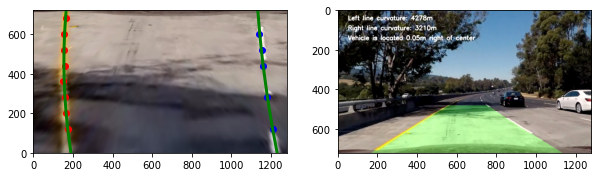

In [12]:
# Get all trhe images using incremental naming convention
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpeg'))

for fname in test_imgs:
    # Get the original image
    lane_detection_pipeline(fname)

# 6. Form the pipeline

In [13]:
def pipeline_debug(img):
    
    # Getting undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    transformed = thresholding(undist)
    
    # Calling the lane detection method
    lane_detection = LaneDetection(ym_per_pix, xm_per_pix, Minv)
    birdseye_transformed = cv2.warpPerspective(transformed, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    result, left_x, left_y, right_x, right_y, left_fitx, left_y_ext, right_fitx, right_y_ext = \
    lane_detection.FindLines(birdseye_transformed,undist, 80)
    
    return result

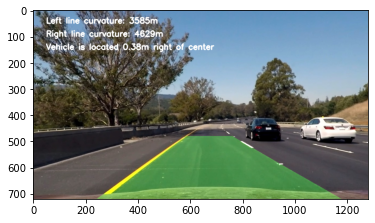

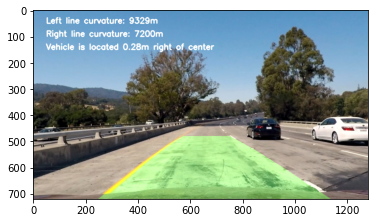

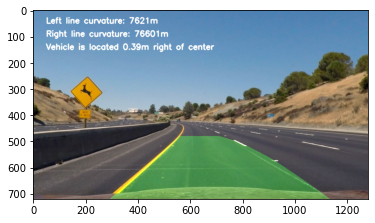

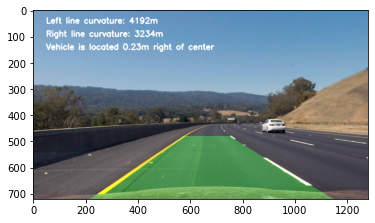

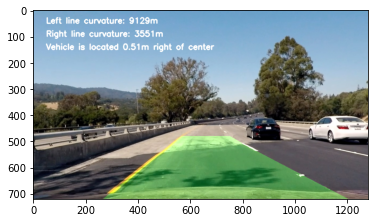

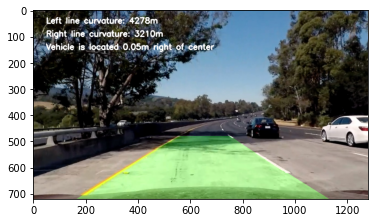

In [14]:
#Testing the pipeline on test images

# Get all trhe images using incremental naming convention
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpeg'))

for fname in test_imgs:
    img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB)
    result = pipeline_debug(img)
    plt.figure()
    plt.imshow(result)
    plt.show()

In [15]:
class Line():
    def __init__(self):
        self.left_pts = np.array(None)
        self.right_pts = np.array(None)
        self.left_curv = 1000
        self.right_curv = 1000
    def FindLines(self, img, undist, step):
        left = []
        right = []
        center = int(img.shape[1]/2)
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        for i in range(img.shape[1] - step, 0, -step):
            histogram = np.sum(img[i:i+step,:], axis = 0)
            left_max_var, left_max_ind = lane_detection.FindMaxInd(histogram, 0, center)
            right_max_var, right_max_ind = lane_detection.FindMaxInd(histogram, center, img.shape[1])
            if(left_max_var > 0):
                left.append((left_max_ind, int((i+i+step)/2)))
            if(right_max_var > 0):
                right.append((right_max_ind, int((i+i+step)/2)))

        left_x = np.array([item[0] for item in left])
        left_y = np.array([item[1] for item in left])
        left_x, left_y = lane_detection.RejectOutlier(left_x, left_y)
        left_fit = np.polyfit(left_y, left_x, 2)
        left_y_ext = np.append(left_y, 0)
        left_y_ext = np.append(720, left_y_ext)
        left_fitx = left_fit[0]*left_y_ext**2 + left_fit[1]*left_y_ext + left_fit[2]

        right_x = np.array([item[0] for item in right])
        right_y = np.array([item[1] for item in right])
        right_x, right_y = lane_detection.RejectOutlier(right_x, right_y)
        right_fit = np.polyfit(right_y, right_x, 2)
        right_y_ext = np.append(right_y, 0)
        right_y_ext = np.append(720, right_y_ext)
        right_fitx = right_fit[0]*right_y_ext**2 + right_fit[1]*right_y_ext + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y_ext]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y_ext])))])
        
        yval = img.shape[1]
        left_fit_cr = np.polyfit(left_y*ym_per_pix, left_x*xm_per_pix, 2)
        right_fit_cr = np.polyfit(right_y*ym_per_pix, right_x*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*yval + left_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*yval + right_fit_cr[1])**2)**1.5) \
                                        /np.absolute(2*right_fit_cr[0])
        if left_curverad < 15000:
            self.left_pts = pts_left
        else:
            pts_left = self.left_pts
            left_curverad = self.left_curv
        
        if right_curverad < 15000:
            self.right_pts = pts_right
        else:
            pts_right = self.right_pts
            right_curverad = self.right_curv
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
         # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result, 'Left line curvature: %dm' % left_curverad, (50,50), font, 1,(255,255,255),3)
        cv2.putText(result, 'Right line curvature: %dm' % right_curverad, (50,100), font, 1,(255,255,255),3)

        lane_middle = left_fitx[0] + (right_fitx[0] - left_fitx[0])/2.0
        deviation = (lane_middle - 640)*xm_per_pix
        if deviation >= 0:
            cv2.putText(result, 'Vehicle is located %.2fm right of center' % deviation, (50,150), font, 1,(255,255,255),3)
        else:
            cv2.putText(result, 'Vehicle is located %.2fm left of center' % -deviation, (50,150), font, 1,(255,255,255),3)
        #ax[0].scatter(left_x, left_y, c = 'r')
        #ax[0].scatter(right_x, right_y, c = 'b')
        #ax[0].plot(left_fitx, left_y_ext, color='green', linewidth=3)
        #ax[0].plot(right_fitx, right_y_ext, color='green', linewidth=3)

        return result, left_x, left_y, right_x, right_y, left_fitx, left_y_ext, right_fitx, right_y_ext

    def pipeline(self, img):
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        transformed = thresholding(undist)
        birdseye_transformed = cv2.warpPerspective(transformed, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        result, left_x, left_y, right_x, right_y, left_fitx, left_y_ext, right_fitx, right_y_ext = \
        self.FindLines(birdseye_transformed,undist, 80)
        return result

In [16]:
line = Line()
clip1 = VideoFileClip("videos/project_video.mp4")
project_clip = clip1.fl_image(line.pipeline)

%time project_clip.write_videofile('videos/proc_project_video.mp4', audio=False)

t:   0%|          | 2/1260 [00:00<01:29, 14.05it/s, now=None]

Moviepy - Building video videos/proc_project_video.mp4.
Moviepy - Writing video videos/proc_project_video.mp4



Moviepy - Done !
Moviepy - video ready videos/proc_project_video.mp4
CPU times: user 2min 46s, sys: 22.1 s, total: 3min 8s
Wall time: 3min 3s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('videos/proc_project_video.mp4'))